<a href="https://colab.research.google.com/github/Wayne122/CMPE257/blob/main/Week1_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE 257 Week 1 Homework

Author: Han-Wei Lin

Dataset source: https://code.datasciencedojo.com/tshrivas/dojoHub/tree/c59bed891626783e706db0982b8f5148fd177824/Wholesale%20Customers

Dataset in-drive ID: 1oVh_Y7qERMetEydoBQq68_df9KKhcRk-

Data:
The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories.

Goal:
To find the general types of customers. We may find a cluster indicating types of customers tend to buy something more or tends to buy something along another item(s).

##Import library and data

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1oVh_Y7qERMetEydoBQq68_df9KKhcRk-"})
downloaded.GetContentFile('dataset.csv')

data = pd.read_csv('dataset.csv')
data.drop(['Channel', 'Region'], axis=1, inplace=True)
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


##Visualize data

###1. Heatmap

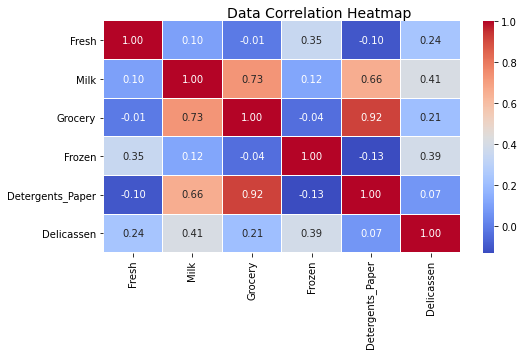

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8, 4))
corr = data.corr()
hm = sns.heatmap(round(corr, 2), annot=True, ax=ax, cmap="coolwarm", fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Data Correlation Heatmap', fontsize=14)

###2. Pair-wise scatter plots

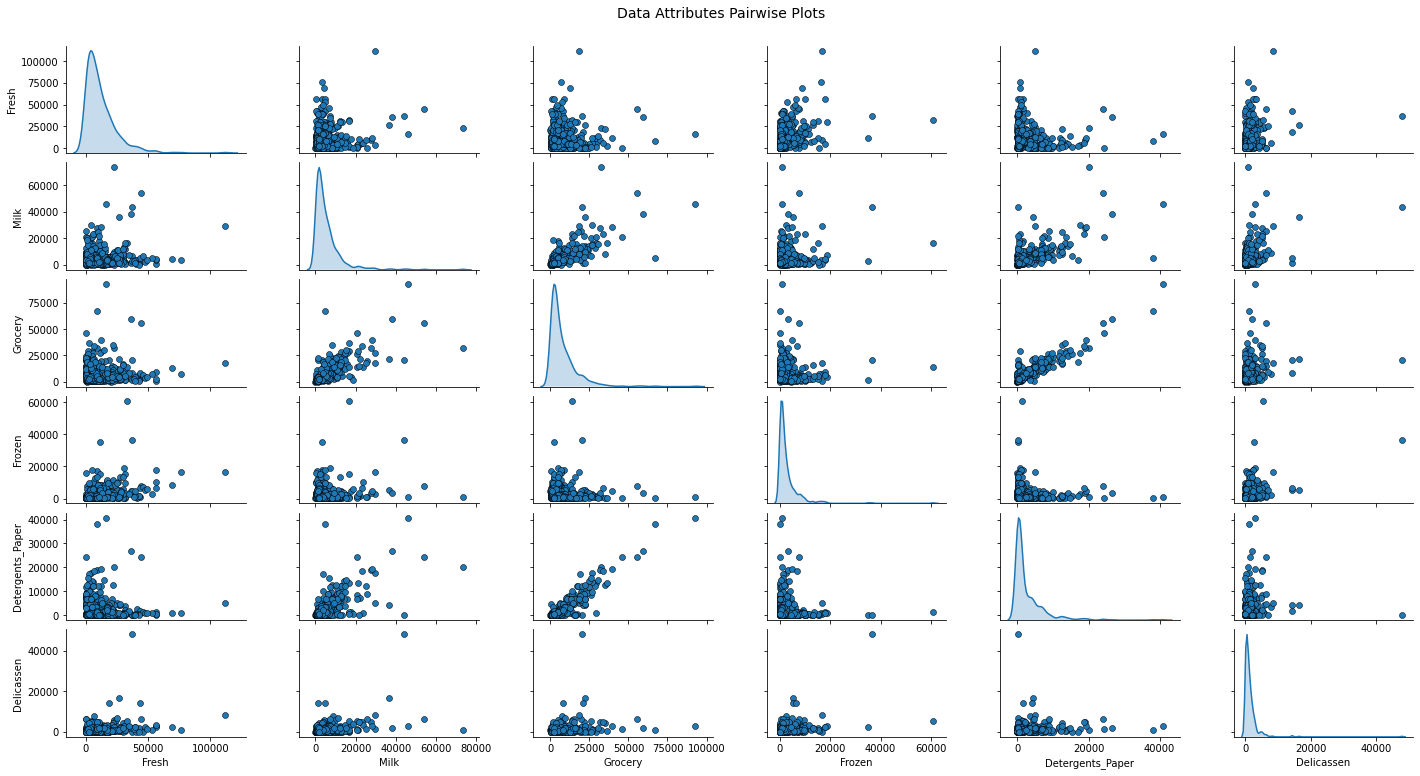

In [ ]:
pp = sns.pairplot(data, height=1.8, aspect=1.8, plot_kws=dict(edgecolor="k", linewidth=0.5), diag_kind="kde", diag_kws=dict(shade=True))
fig = pp.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Data Attributes Pairwise Plots', fontsize=14)

## Scikit

###Import necessary Scikit packages

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

###Normalize data

In [ ]:
transformer = MinMaxScaler().fit(data)
data_normalized = transformer.transform(data)

###Find best k value

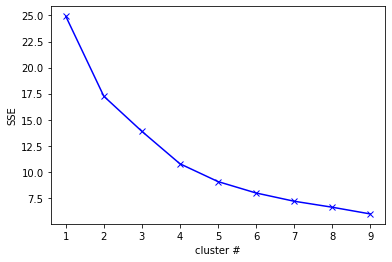

In [ ]:
sse = []
K = range(1, 10)
for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans = kmeans.fit(data_normalized)
  sse.append(kmeans.inertia_)

plt.plot(K, sse, 'bx-')
plt.xlabel('cluster #')
plt.ylabel('SSE')
plt.show()

Best k is 4

###Combine cluster information to data

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(data_normalized)

labeled_data = pd.DataFrame(data=kmeans.labels_, columns=['Cluster'])
labeled_data = pd.concat([data, labeled_data], axis=1)
labeled_data

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,12669,9656,7561,214,2674,1338,2
1,7057,9810,9568,1762,3293,1776,2
2,6353,8808,7684,2405,3516,7844,2
3,13265,1196,4221,6404,507,1788,2
4,22615,5410,7198,3915,1777,5185,3
...,...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204,3
436,39228,1431,764,4510,93,2346,3
437,14531,15488,30243,437,14841,1867,1
438,10290,1981,2232,1038,168,2125,2


###Visualize data

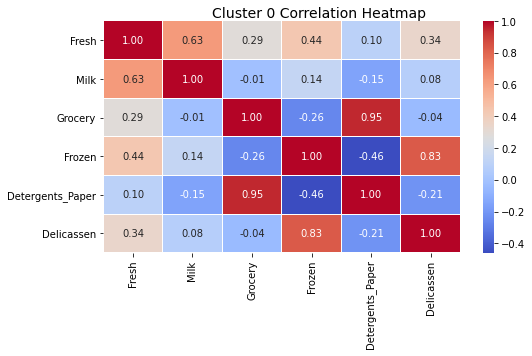

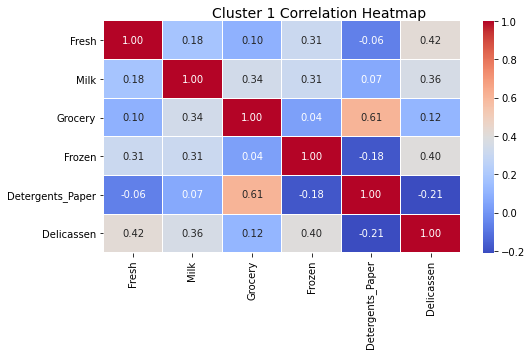

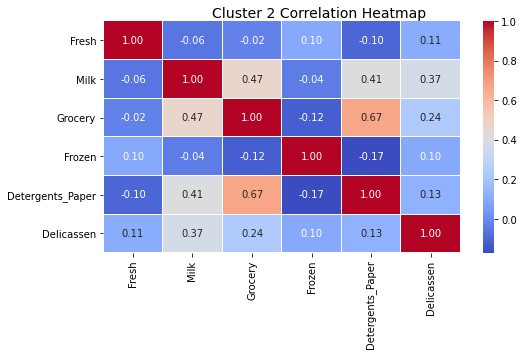

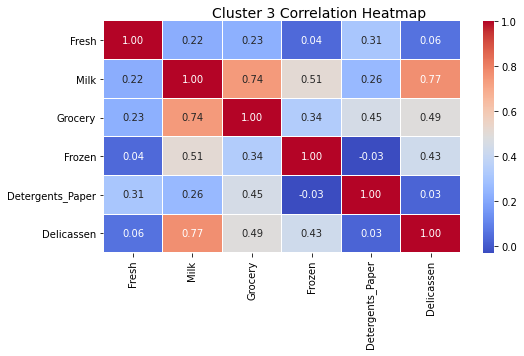

In [ ]:
for i in range(0, 4):
  f, ax = plt.subplots(figsize=(8, 4))
  corr = data[labeled_data['Cluster']==i].corr()
  hm = sns.heatmap(round(corr, 2), annot=True, ax=ax, cmap="coolwarm", fmt='.2f', linewidths=.05)
  f.subplots_adjust(top=0.93)
  t= f.suptitle('Cluster ' + str(i) + ' Correlation Heatmap', fontsize=14)

###Output file and inspect

In [ ]:
from google.colab import files
labeled_data.sort_values(by=['Cluster'], inplace=True)
labeled_data.to_csv("labeled_data_scikit.csv")
files.download("labeled_data_scikit.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## PyTorch

###Import necessary PyTorch packages and install kmeans-pytorch
We use MinMaxScaler from scikit to normalize the data.

In [ ]:
import torch
!pip install kmeans-pytorch
from kmeans_pytorch import kmeans
from sklearn.preprocessing import MinMaxScaler

###Normalize data

In [ ]:
transformer = MinMaxScaler().fit(data)
data_normalized = transformer.transform(data)

###Initailize training

In [ ]:
tensor_data = torch.from_numpy(data_normalized)

# set device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

###Implement SSE function

In [ ]:
def ssef(tensor_data, labels, ccs):
  sse = 0.0

  for i, v in enumerate(labels):
    sse += float(torch.sum((tensor_data[i] - ccs[int(v)]) ** 2))
  
  return sse

###Find best k value

[running kmeans]: 0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/kmeans_pytorch/__init__.py:63: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  selected = torch.nonzero(choice_cluster == index).squeeze().to(device)
[running kmeans]: 5it [00:00,  7.44it/s, center_shift=0.004908, iteration=6, tol=0.000100]

running k-means on cpu..


[running kmeans]: 17it [00:00, 83.59it/s, center_shift=0.000026, iteration=17, tol=0.000100]
[running kmeans]: 12it [00:00, 232.77it/s, center_shift=0.000034, iteration=12, tol=0.000100]
[running kmeans]: 10it [00:00, 231.88it/s, center_shift=0.000014, iteration=10, tol=0.000100]
[running kmeans]: 15it [00:00, 391.21it/s, center_shift=0.000099, iteration=15, tol=0.000100]

running k-means on cpu..
running k-means on cpu..
running k-means on cpu..



[running kmeans]: 12it [00:00, 234.56it/s, center_shift=0.000079, iteration=12, tol=0.000100]
[running kmeans]: 14it [00:00, 230.71it/s, center_shift=0.000058, iteration=14, tol=0.000100]
[running kmeans]: 2it [00:00, 193.22it/s, center_shift=0.072226, iteration=3, tol=0.000100]

running k-means on cpu..
running k-means on cpu..
running k-means on cpu..


[running kmeans]: 14it [00:00, 238.93it/s, center_shift=0.000039, iteration=14, tol=0.000100]
[running kmeans]: 15it [00:00, 220.34it/s, center_shift=0.000071, iteration=15, tol=0.000100]
[running kmeans]: 22it [00:00, 242.06it/s, center_shift=0.000000, iteration=22, tol=0.000100]
[running kmeans]: 0it [00:00, ?it/s]

running k-means on cpu..
running k-means on cpu..
running k-means on cpu..


[running kmeans]: 26it [00:00, 245.81it/s, center_shift=0.000027, iteration=26, tol=0.000100]
[running kmeans]: 16it [00:00, 256.00it/s, center_shift=0.000000, iteration=16, tol=0.000100]
[running kmeans]: 14it [00:00, 163.11it/s, center_shift=0.000864, iteration=15, tol=0.000100]

running k-means on cpu..
running k-means on cpu..


[running kmeans]: 22it [00:00, 180.52it/s, center_shift=0.000000, iteration=22, tol=0.000100]
[running kmeans]: 17it [00:00, 200.00it/s, center_shift=0.000005, iteration=17, tol=0.000100]


running k-means on cpu..


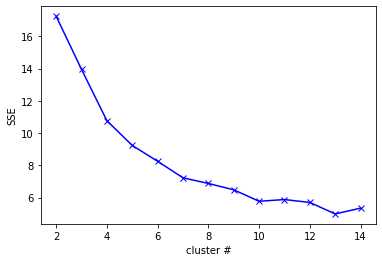

In [ ]:
# k-means
sse = []
K = range(2, 15)
for k in K:
  labels, cluster_centers = kmeans(tensor_data, num_clusters=k)
  sse.append(ssef(tensor_data, labels, cluster_centers))

plt.plot(K, sse, 'bx-')
plt.xlabel('cluster #')
plt.ylabel('SSE')
plt.show()

###Combine cluster information to data

In [ ]:
labels, cluster_centers = kmeans(tensor_data, num_clusters=5)

labeled_data = pd.DataFrame(data=labels.numpy(), columns=['Cluster'])
labeled_data = pd.concat([data, labeled_data], axis=1)
labeled_data

[running kmeans]: 15it [00:00, 189.81it/s, center_shift=0.000028, iteration=15, tol=0.000100]

running k-means on cpu..


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,12669,9656,7561,214,2674,1338,0
1,7057,9810,9568,1762,3293,1776,0
2,6353,8808,7684,2405,3516,7844,0
3,13265,1196,4221,6404,507,1788,0
4,22615,5410,7198,3915,1777,5185,1
...,...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204,1
436,39228,1431,764,4510,93,2346,1
437,14531,15488,30243,437,14841,1867,4
438,10290,1981,2232,1038,168,2125,0


###Visualize data

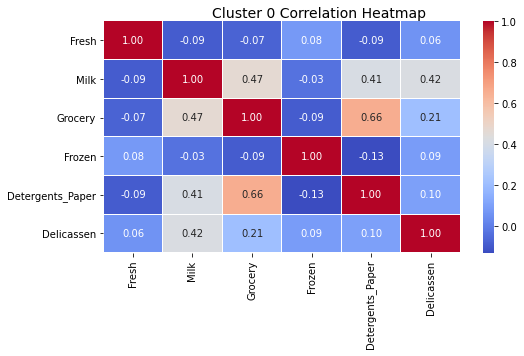

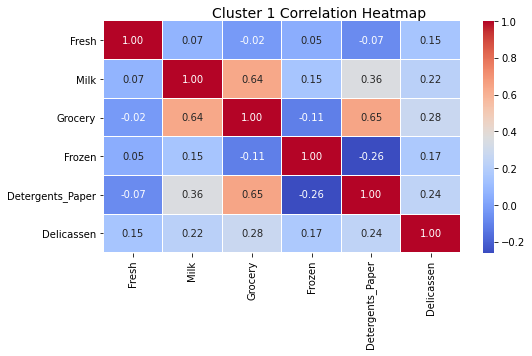

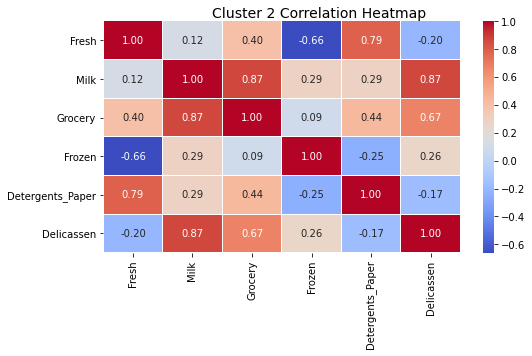

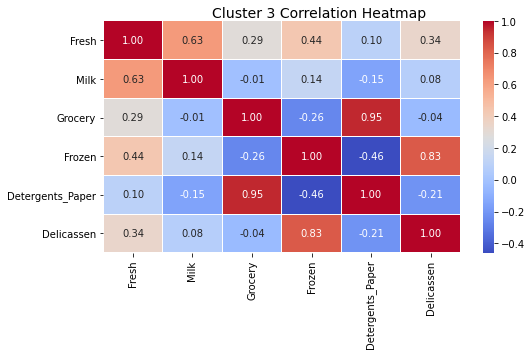

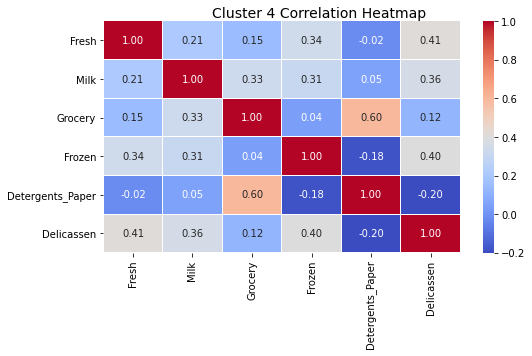

In [ ]:
for i in range(0, 5):
  f, ax = plt.subplots(figsize=(8, 4))
  corr = data[labeled_data['Cluster']==i].corr()
  hm = sns.heatmap(round(corr, 2), annot=True, ax=ax, cmap="coolwarm", fmt='.2f', linewidths=.05)
  f.subplots_adjust(top=0.93)
  t= f.suptitle('Cluster ' + str(i) + ' Correlation Heatmap', fontsize=14)

###Output file and inspect

In [ ]:
from google.colab import files
labeled_data.sort_values(by=['Cluster'], inplace=True)
labeled_data.to_csv("labeled_data_pytorch.csv")
files.download("labeled_data_pytorch.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Conclusion

The data is telling us that all the customers can be roughly divided into a certain number of groups; divided into four groups using Scikit and five groups using PyTorch. Customers of each group are likely to have a similar buying habit, for example, a group in Scikit-processed dataset indicates that customers of the group spent a lot more on detergents paper than others.

We can use this data to know what kind of product is more popular, promoting that product may be more effective. Or we can even tell a certain combination of products is usually bought together.

##References:

https://code.datasciencedojo.com/tshrivas/dojoHub/tree/c59bed891626783e706db0982b8f5148fd177824/Wholesale%20Customers

https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/

https://scikit-learn.org/stable/modules/preprocessing.html

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

https://intellipaat.com/community/1867/scikit-learn-k-means-elbow-criterion

https://www.kite.com/python/answers/how-to-create-pandas-dataframe-from-a-numpy-array-in-python

https://jakevdp.github.io/PythonDataScienceHandbook/03.06-concat-and-append.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html

https://stackoverflow.com/questions/48854943/how-can-i-download-a-pandas-dataframe-in-google-colab

https://github.com/subhadarship/kmeans_pytorch/blob/master/example.ipynb

https://discuss.pytorch.org/t/pytorch-tensor-scaling/38576

https://pytorch.org/docs/stable/generated/torch.sum.html

https://stackoverflow.com/questions/57942487/how-to-convert-torch-tensor-to-pandas-dataframe

https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57